In [1]:
import numpy as np
import os
import pandas as pd
import pyodbc
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from collections import Counter
from datetime import datetime
import sys
import gc
from scipy.sparse import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle 
import random
import math
from joblib import dump, load
import matplotlib
import json
import string


In [3]:
dataset = 'mdcd_3yrs'
features = 'fullfeatures'

output_folder = f'figures_skiptrain_6mo_{features}/'

with open(f'{int_data_path}/9_26_mdcd_2dx_fullhistory_du_snomed_colnames', "rb") as fp:   #Pickling
    data_columns = pickle.load(fp)
    
df_data = pd.read_csv(f'{int_data_path}/causal_data/10_15_causal_raw_data.csv')
test_outputs = pd.read_csv(f'{output_folder}/test_outputs.csv', parse_dates = ['date_prediction'])

df_tte = pd.read_csv(f'{int_data_path}/9_26_mdcd_2dx_fullhistory_time_to_event.csv', parse_dates = ['interval_end_date'])
test_outputs = test_outputs.merge(df_tte[['person_id', 'interval_end_date', 'iteration']], left_on = ['person_id', 'date_prediction'], right_on = ['person_id', 'interval_end_date'], how = 'inner')
df_data = df_data.merge(test_outputs[['person_id', 'iteration', 'y_pred', 'y_true']], how = 'inner', on = ['person_id', 'iteration'])

# Stability Analysis

In [4]:
# STABILITY ANALYSIS
prob_col = 'y_pred'
eps = 1e-10

patient_loss = -1*((df_data['y_true']*np.log(df_data['y_pred']))+(1-df_data['y_true'])*(np.log(1-df_data['y_pred']+eps)))
df_data['bce_loss'] = patient_loss
cond_cols = [i for i in data_columns if '_conds' in i]
med_cols = [i for i in data_columns if '_meds' in i]
procedure_cols = [i for i in data_columns if '_procedure' in i]
lab_cols = [i for i in data_columns if '_lab' in i]
forward_visit_features = [i for i in data_columns if ('num_visits' in i)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.26s/it]


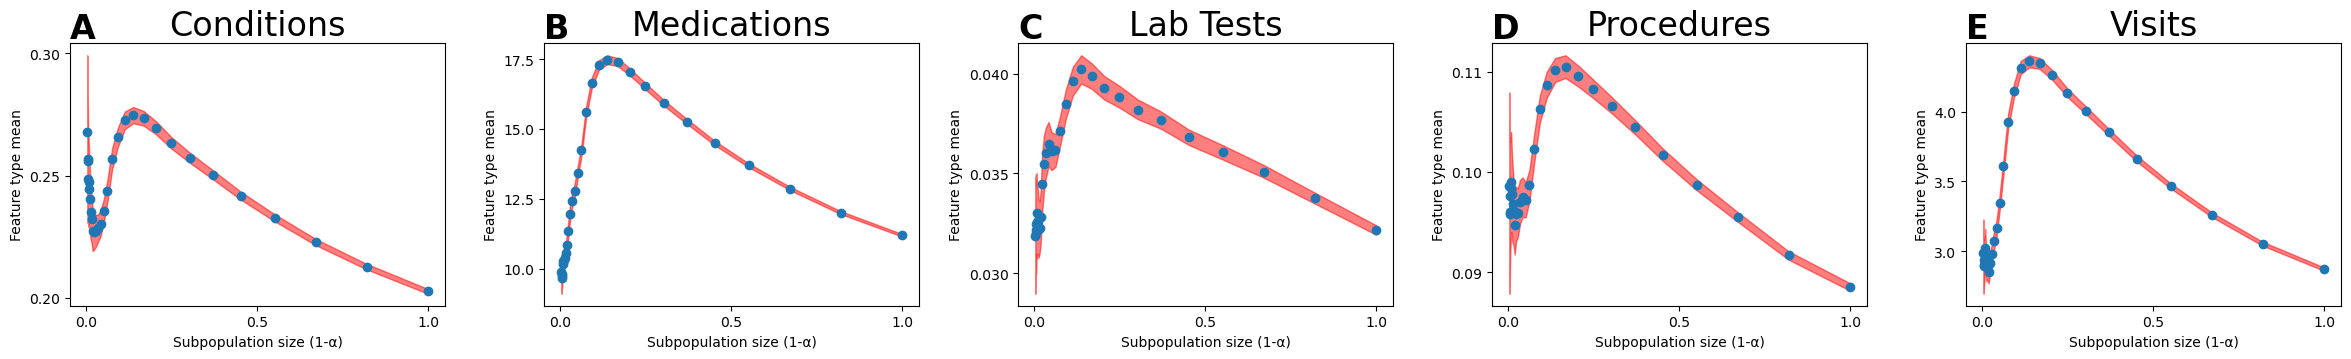

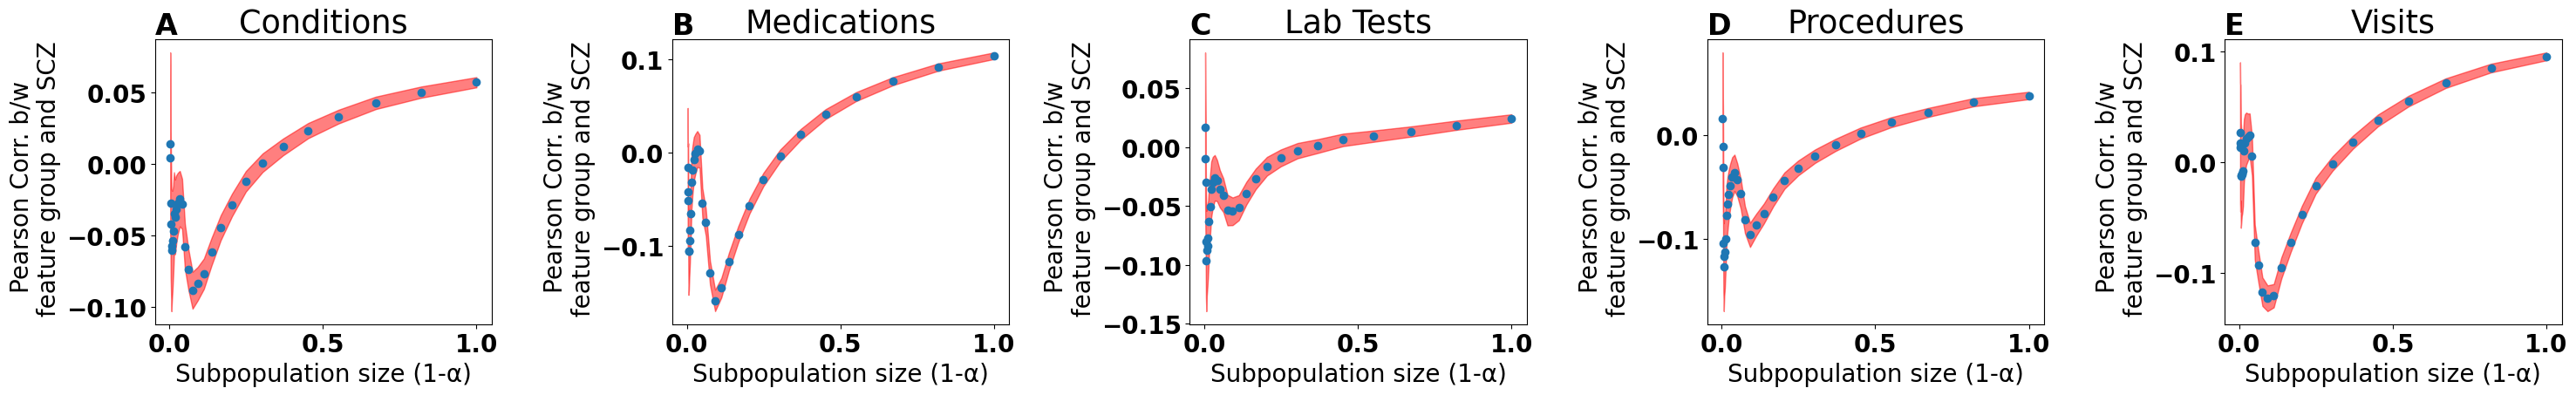

In [5]:
df_index = ['Conditions', 'Medications', 'Lab Tests', 'Procedures', 'Visits']
list_alphas = 1-np.logspace(-2.5, 0, 30)
results_ci95 = pd.DataFrame(index=df_index, columns=(1-list_alphas))
results_mean = pd.DataFrame(index=df_index, columns=(1-list_alphas))

results_correlation = pd.DataFrame(index=df_index, columns=(1-list_alphas))
results_correlation_ci95 = pd.DataFrame(index=df_index, columns=(1-list_alphas))

df_test = pd.DataFrame(df_data[data_columns])
df_test['y_true'] = df_data['y_true']
df_test['bce_loss'] = df_data['bce_loss']

for a_ind in tqdm(range(len(list_alphas))):
    alpha = list_alphas[a_ind]
    alpha_worst = df_data['bce_loss'].sort_values(ascending=False).iloc[0:int(np.floor(len(df_data)*(1-alpha)))]
    test_worst = df_test.loc[alpha_worst.index]
    for list_cols, name_list_cols in zip([cond_cols, med_cols, lab_cols, procedure_cols, forward_visit_features], results_ci95.index):
        
        # getting overall feature values
        grouped_mean = test_worst[list_cols].mean(axis=1)
        ci_low, ci_high = stats.t.interval(0.95, len(test_worst)-1, loc=grouped_mean.mean(), scale=stats.sem(grouped_mean))
        ci95 = ci_high-grouped_mean.mean()
        
        results_mean.loc[name_list_cols, 1-alpha] = grouped_mean.mean()
        results_ci95.loc[name_list_cols, 1-alpha] = ci95
        
        # getting correlation between schizophrenia onset and feature values
        corr_val = test_worst['y_true'].corr(grouped_mean)
        corr_ci_low, corr_ci_high = stats.pearsonr(test_worst['y_true'], grouped_mean).confidence_interval(confidence_level=0.95)
        corr_ci95 = corr_ci_high-corr_val

        results_correlation.loc[name_list_cols, 1-alpha] = corr_val
        results_correlation_ci95.loc[name_list_cols, 1-alpha] = corr_ci95

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,4))

font = {'size':20,
       'weight':'bold'}
matplotlib.rc('font', **font)

for i in range(0, 5):
    plt.subplot(1,5,i+1)
    ax = axes[i]
    col = results_mean.index[i]
    plt.plot(1-list_alphas, results_mean.loc[col], 'o')
    ci_low = np.asarray(results_mean.loc[col]-results_ci95.loc[col]).astype(float)
    ci_high = np.asarray(results_mean.loc[col]+results_ci95.loc[col]).astype(float)
    plt.fill_between(1-list_alphas, ci_low, ci_high, color='red', alpha=0.5)
    
    plt.ylabel('Feature type mean')
    plt.xlabel('Subpopulation size (1-α)')
    plt.title(col)
    ax.text(0, 1.02, string.ascii_uppercase[i], transform=ax.transAxes, size=24, weight='bold')
    
plt.tight_layout()


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
font = {'size':22,
       'weight':'bold'}
matplotlib.rc('font', **font)

for i in range(0, 5):
    ax = axes[i]
    plt.subplot(1,5,i+1)
    col = results_mean.index[i]
    plt.plot(1-list_alphas, results_correlation.loc[col], 'o')
    ci_low = np.asarray(results_correlation.loc[col]-results_correlation_ci95.loc[col]).astype(float)
    ci_high = np.asarray(results_correlation.loc[col]+results_correlation_ci95.loc[col]).astype(float)
    plt.fill_between(1-list_alphas, ci_low, ci_high, color='red', alpha = 0.5)
    
    plt.ylabel('Pearson Corr. b/w \n feature group and SCZ')
    plt.xlabel('Subpopulation size (1-α)')
    plt.title(col)
    ax.text(0, 1.02, string.ascii_uppercase[i], transform=ax.transAxes, size=24, weight='bold')
    matplotlib.rc('font', **font)
    
plt.tight_layout()
plt.savefig(f'{output_folder}/stability_analysis.pdf', dpi=300)
plt.show()

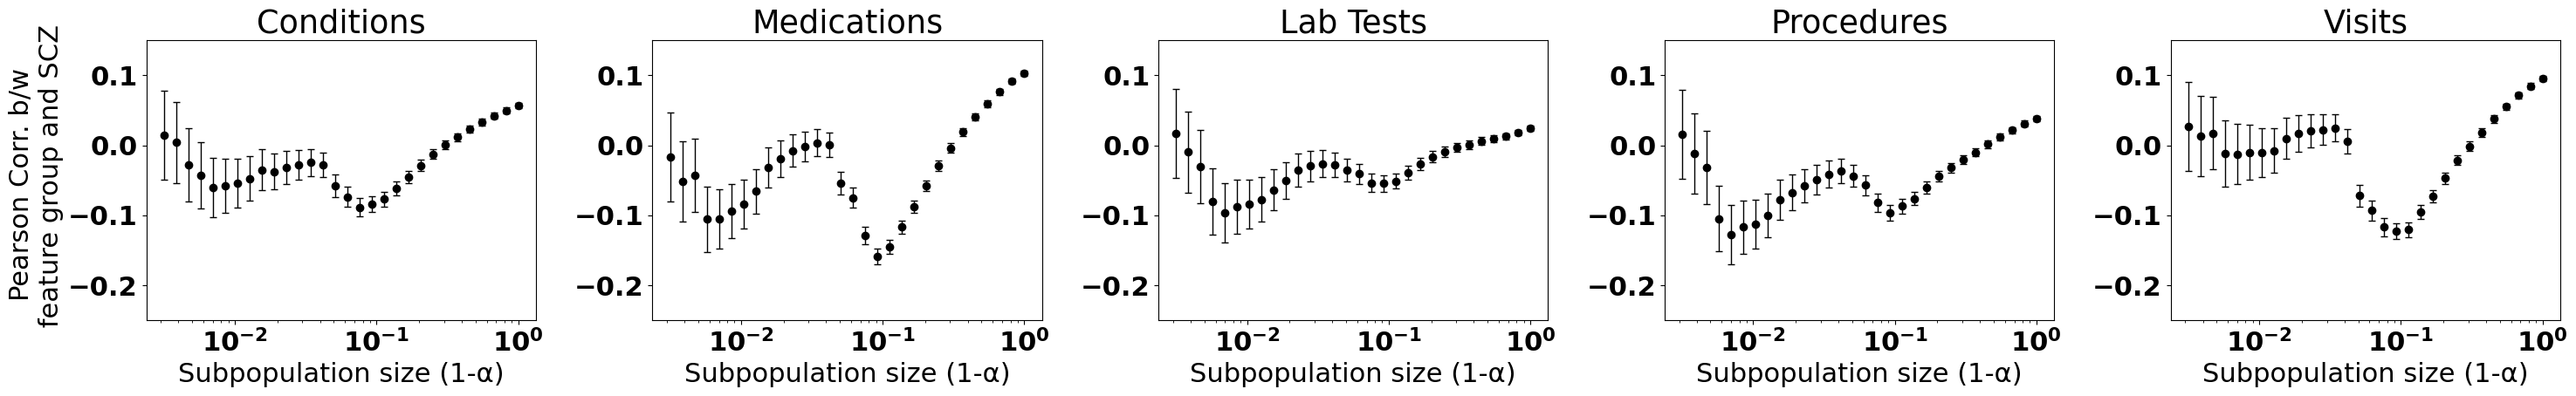

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,5))
font = {'size':22,
       'weight':'bold'}
matplotlib.rc('font', **font)

for i in range(0, 5):
    ax = axes[i]
    plt.subplot(1,5,i+1)
    col = results_mean.index[i]
    plt.errorbar(1-list_alphas, results_correlation.loc[col], yerr=results_correlation_ci95.loc[col], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)    
    plt.xlabel('Subpopulation size (1-α)')
    plt.xscale('log')
    plt.ylim([-0.25, 0.15])
    plt.title(col)
    matplotlib.rc('font', **font)
axes[0].set_ylabel('Pearson Corr. b/w \n feature group and SCZ')

    
plt.tight_layout()
plt.savefig(f'{output_folder}/stability_analysis.pdf', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
import scipy.stats as stats
from sklearn.metrics import *
import sys
import seaborn as sns

sys.path.append('../')
from eval_utils import * 

dataset = 'mdcd_3yrs'
model_name = 'grud_fullhistory_long_top500'
data_path = f'/data2/processed_datasets/ak4885/psychosis_schizophrenia_prediction/raw_data_{dataset}'
int_data_path = f'/data2/processed_datasets/ak4885/psychosis_schizophrenia_prediction/intermediate_data_{dataset}'
model_path = f'../long_model_training/models/{model_name}'
feature_type = 'top500'
output_folder = f'figures_{feature_type}'

test_output = pd.read_csv(f'results_{feature_type}/test_outputs.csv')
test_hcu = pd.read_csv(f'../figures/hcu_grud_fullhistory_long/test_outputs_with_utilization.csv')
test_hcu.drop(['y_pred'], axis=1, inplace=True)

test_hcu = test_hcu.loc[test_hcu['days_since_start'] >= 365]
test_hcu = test_hcu.merge(test_output[['person_id', 'date_prediction', 'y_binary_pred']], how = 'inner', on = ['person_id', 'date_prediction'])

trainval_hcu = pd.read_csv(f'../figures/hcu_grud_fullhistory_long/trainval_outputs_with_utilization.csv')
trainval_hcu = trainval_hcu.loc[trainval_hcu['days_since_start']>=365]

list_visitnames = ['pharmacy', 'outpatient',  'inpatientedcombo', 'allvisits']
# get HCU deciles
decile_dict = {}
for name in list_visitnames:
    for prefix in ['all', 'mh', 'nonmh']:
        for suffix in ['hcu', '1yr_visits']:
            col = f'{prefix}_{name}_{suffix}'
            decile_dict[col] = np.percentile(trainval_hcu[col], np.linspace(0, 100, 10))

test_hcu['Prediction Type'] = 'TN'
test_hcu.loc[(test_hcu['y_true']==1) & (test_hcu['y_binary_pred'] == 1), 'Prediction Type'] = 'TP'
test_hcu.loc[(test_hcu['y_true']==1) & (test_hcu['y_binary_pred'] == 0), 'Prediction Type'] = 'FN'
test_hcu.loc[(test_hcu['y_true']==0) & (test_hcu['y_binary_pred'] == 1), 'Prediction Type'] = 'FP'

def plot_hcu_by_prediction_type(df):
    # Define your setting groups
    setting_groups = {
        "Pharmacy": ["mh_pharmacy_hcu", "nonmh_pharmacy_hcu"],
        "Inpatient and ED": ["mh_inpatientedcombo_hcu", "nonmh_inpatientedcombo_hcu"],
        "Outpatient": ["mh_outpatient_hcu", "nonmh_outpatient_hcu"]
    }

    pred_types = ["TP", "FP", "TN", "FN"]
    colors = {
        "TP": "#4daf4a",  # green
        "FP": "#e41a1c",  # red
        "TN": "orange",  # 
        "FN": "#377eb8"   # blue
    }

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    for ax, (setting_name, cols) in zip(axes, setting_groups.items()):
        means = []
        sems = []
        for col in cols:
            group_stats = df.groupby("Prediction Type")[col].agg(["mean", "sem"]).reindex(pred_types)
            means.append(group_stats["mean"].values)
            sems.append(group_stats["sem"].values)

        means = np.array(means)  # shape (3, 4)
        sems = np.array(sems)

        x = np.arange(len(cols))
        width = 0.18

        for i, ptype in enumerate(pred_types):
            ax.bar(
                x + i * width - 1.5 * width,
                means[:, i],
                yerr=sems[:, i],
                width=width,
                color=colors[ptype],
                label=ptype if setting_name == "Outpatient" else None,  # one legend
                capsize=4,
            )  
        ax.set_xticks(x)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
            label.set_fontsize(22)
        ax.set_xticklabels(["Mental Health", "Non-Mental Health"], fontsize=22, fontweight="bold")
        ax.set_title(setting_name, fontsize=24, fontweight="bold")
        ax.set_ylim([0, 85])
        ax.set_xlabel("")

    axes[0].set_ylabel("Percentile of utilization", fontsize=22, fontweight="bold")
    axes[-1].legend(pred_types, loc="lower right", fontsize = 24)
    plt.tight_layout()
    plt.show()
    return fig

def replace_with_percentiles(test_outputs, trainval_outputs, list_columns):
    test_outputs = test_outputs.copy()
    
    for col in list_columns:
        # Get the training distribution (drop NaNs)
        train_values = trainval_outputs[col].dropna().values
        
        # Sort training values once
        sorted_train = np.sort(train_values)
        
        # Compute percentile rank for each test value
        ranks = np.searchsorted(sorted_train, test_outputs[col].values, side='right')
        percentiles = 100 * ranks / len(sorted_train)
        
        # Replace column with percentile values
        test_outputs[col] = percentiles
    
    return test_outputs

list_cols_percentiles = ["mh_pharmacy_hcu", "nonmh_pharmacy_hcu",
                        "mh_inpatientedcombo_hcu", "nonmh_inpatientedcombo_hcu",
                        "mh_outpatient_hcu", "nonmh_outpatient_hcu"]
test_hcu = replace_with_percentiles(test_hcu, trainval_hcu, list_cols_percentiles)
fig = plot_hcu_by_prediction_type(test_hcu)


In [ ]:
fig